#Test run for stock price prediction using SAP stock data and RNN - LSTM

# Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


# Import packages (some are not used)

In [3]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import numpy as np
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

# Load data

In [4]:
#load data
dax=pd.read_csv('/gdrive/MyDrive/Colab Notebooks/SAP.csv', delimiter=',')
dax.info()
#remove columns we dont need
dax = dax.drop(dax.columns[[2, 3, 4, 5]], axis=1)
#fill missing values
dax['Open'].interpolate(method='index', inplace=True)

dax.info()
#252 days, no value is empty

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       252 non-null    object 
 1   Open       252 non-null    float64
 2   High       252 non-null    float64
 3   Low        252 non-null    float64
 4   Close      252 non-null    float64
 5   Adj Close  252 non-null    float64
 6   Volume     252 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 13.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    252 non-null    object 
 1   Open    252 non-null    float64
 2   Volume  252 non-null    int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 6.0+ KB


# Split data

In [10]:
#split 80/20
training_size = int(0.8*len(dax))

x_train = dax.iloc[0:training_size-1, 1:2].values
y_train = dax.iloc[1:training_size, 1:2].values

x_test = dax.iloc[training_size:-1, 1:2].values
y_test = dax.iloc[training_size+1:, 1:2].values

print(x_train[1, :])#first value is price, second value is volume(not used in this notebook)
print(y_train[0, :])#shifted training data by 1
print(np.shape(x_train))
print(np.shape(y_train))

[132.860001]
[132.860001]
(200, 1)
(200, 1)


# Normalize data

In [11]:
#### Normalization: 
    # Normalization AFTER splitting data 
    #As with all the transformations, it is important 
    #to fit the scalers to the training data only, 
    #not to the full dataset (including the test set). 
    #Only then can you use them to transform the training 
    #set and the test set (and new data).
scaler = MinMaxScaler(feature_range = (0, 1))
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
y_train_scaled = scaler.transform(y_train)
y_test_scaled = scaler.transform(y_test)

del(x_train, x_test)

# Construct LSTM

In [12]:
# creating a data structure with 1 time-step and 1 output
#( Number of observations , Number of Timesteps , Number of input series )

x_train_scaled = np.reshape(x_train_scaled, (x_train_scaled.shape[0], 1, x_train_scaled.shape[1]))
y_train_scaled = np.reshape(y_train_scaled, (y_train_scaled.shape[0], 1, y_train_scaled.shape[1]))
x_test_scaled = np.reshape(x_test_scaled, (x_test_scaled.shape[0], 1, x_test_scaled.shape[1]))

print(np.shape(x_train_scaled))
print(np.shape(y_train_scaled))

(200, 1, 1)
(200, 1, 1)


In [13]:


#from keras.callbacks import EarlyStopping, ReduceLROnPlateau
#early_stopping = EarlyStopping(monitor='val_loss', patience=1, mode='auto')

#create model
model = Sequential()
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, input_shape = (x_train_scaled.shape[1], 1), return_sequences=True))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(Dense(128, activation='tanh'))
model.add(LSTM(128, dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(1, activation='tanh'))
#opt = tf.keras.optimizers.Adam(clipnorm=1.0)#for exploding gradient problem
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1, 128)            66560     
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 128)            131584    
_________________________________________________________________
dense_2 (Dense)              (None, 1, 128)            16512     
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 346,369
Trainable params: 346,369
Non-trainable params: 0
_________________________________________________________________


# Fit model on training data

In [14]:
#fit model to training data
model.fit(x_train_scaled, y_train_scaled, 
            epochs=10, batch_size=1, 
            validation_split = 0.2,
            verbose=1,
            )

Epoch 1/10
160/160 [==============================] - 2s 10ms/step - loss: 0.1629 - val_loss: 0.2339
Epoch 2/10
160/160 [==============================] - 1s 7ms/step - loss: 0.1407 - val_loss: 0.3197
Epoch 3/10
160/160 [==============================] - 1s 7ms/step - loss: 0.1261 - val_loss: 0.2755
Epoch 4/10
160/160 [==============================] - 1s 7ms/step - loss: 0.1307 - val_loss: 0.3171
Epoch 5/10
160/160 [==============================] - 1s 7ms/step - loss: 0.1305 - val_loss: 0.3455
Epoch 6/10
160/160 [==============================] - 1s 7ms/step - loss: 0.1320 - val_loss: 0.2930
Epoch 7/10
160/160 [==============================] - 1s 7ms/step - loss: 0.1218 - val_loss: 0.3280
Epoch 8/10
160/160 [==============================] - 1s 7ms/step - loss: 0.1185 - val_loss: 0.2973
Epoch 9/10
160/160 [==============================] - 1s 7ms/step - loss: 0.1162 - val_loss: 0.2267
Epoch 10/10
160/160 [==============================] - 1s 7ms/step - loss: 0.1078 - val_loss: 0.182

# Get forecast from test data

In [15]:
#get forecast from applying model to test data
prediction = model.predict(x_test_scaled)
prediction = scaler.inverse_transform(prediction)

# Visualize model Performance

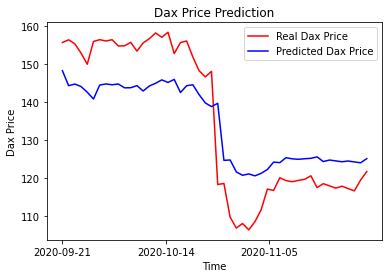

In [16]:
# Visualizing the results
time = dax.loc[training_size+1:, 'Date']
plt.clf()
plt.plot(time[-50:], y_test[-50:], color = 'r', label = 'Real Dax Price')
plt.plot(time[-50:], prediction[-50:], color = 'b', label = 'Predicted Dax Price')
plt.xticks(np.arange(0,len(y_test),len(y_test)/3))
plt.title('Dax Price Prediction')
plt.xlabel('Time')
plt.ylabel('Dax Price')
plt.legend()
plt.show()